# Benchmark against non-learning based Watershed method

- 3D Watershed

In [123]:
import os
import sys
import gc
import time


import h5py
import tifffile
import napari
import numpy as np
import pandas as pd

import SimpleITK as sitk

from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.filters import gaussian

from cellpose import plot as cp_plot

In [2]:
sys.path.append('..')
from cellstitch import evaluation

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager

from IPython.display import display
from matplotlib import rcParams

sns.set_style('white')

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 15})

params = {'mathtext.default': 'regular'}
plt.rcParams.update(params)

### 3D Watershed

Steps:
- Preprocesing
- Generate seeds w/ H-minima filter
- Seeded 3D Watershed w/ SimpleITK

Util functions

In [47]:
def _itk2np(img):
    return sitk.GetArrayFromImage(img)

def _np2itk(img):
    return sitk.GetImageFromArray(img)

def _mask_to_rgb(mask):
    n_lbls = evaluation.get_num_cells(mask)
    colors = np.random.random((n_lbls, 3))
    rgb = label2rgb(mask, colors=colors, bg_label=0)
    return rgb


In [159]:
def get_fg_mask(img_itk, level=4):
    """
    Obtain semantic mask for foreground
    """
    ws_img_itk = sitk.MorphologicalWatershed(
        img_itk,
        level=level,
        markWatershedLine=False,
        fullyConnected=False
    )
    
    # Get filled-in semantic object masks
    seg = sitk.ConnectedComponent(ws_img_itk != ws_img_itk[0, 0, 0])
    filled = sitk.BinaryFillhole(seg != 0)
    return filled
    
    
def find_seeds(img_itk, bin_mask, do_roi_filter=True, h_threshold=10):
    h_minima = sitk.HMinima(img_itk, height=h_threshold)  # Regional minima
    local_minima = _itk2np(img_itk) - _itk2np(h_minima)
    if do_roi_filter:
        seed_mask = np.logical_and(local_minima < 0, _itk2np(bin_mask) == 1).astype(np.uint8)
    else:
        seed_mask = (local_minima < 0).astype(np.uint8)
    seeds = sitk.ConnectedComponent(_np2itk(seed_mask) > 0)
    return seeds


def min_vol_filter(pred, min_vol=200):
    """
    Remove FPs with excessively low volume size
    """
    prop_df = pd.DataFrame(regionprops_table(pred, properties=('label', 'area')))
    prop_df.set_index('label', append=False, inplace=True)
    
    labels_to_keep = prop_df[prop_df.area >= min_vol].index
    vol_mask = ~np.isin(pred, labels_to_keep)
    pred[vol_mask] = 0
    
    # Relabel remaining labels exceeding the volume threshold
    filtered_pred = pred.copy()
    for i, lbl in enumerate(labels_to_keep):
        filtered_pred[pred == lbl] = i+1
    return filtered_pred


def watershed_3d(
    img_itk,
    do_gaussian_blur=True,
    sigma=1,
    lvl=4,
    min_volume=200
):
    # Gaussian Smoothing & Gradient calculation
    img_itk = sitk.GradientMagnitudeRecursiveGaussian(img_itk, sigma=sigma)
    
    # Get binary Foreground/Background mask
    roi_mask = get_fg_mask(img_itk, lvl)
    
    # Calculate marker seeds
    seeds = find_seeds(img_itk, roi_mask)
    
    # Watershed
    ws = sitk.MorphologicalWatershedFromMarkers(
        img_itk, seeds, markWatershedLine=True
    )
    ws = sitk.Mask(ws, roi_mask)
    
    return ws


### Ovules 

In [201]:
ovules_path = '../data/ovules/test/'

fnames = [
    f.rpartition('.')[0]
    for f in sorted(os.listdir(ovules_path))
]

imgs = [
    h5py.File(os.path.join(ovules_path, f))['raw'][:]
    for f in sorted(os.listdir(ovules_path))
    if f[-2:] == 'h5'
]

masks = [
    h5py.File(os.path.join(ovules_path, f))['label'][:]
    for f in sorted(os.listdir(ovules_path))
    if f[-2:] == 'h5'
]

del ovules_path

#### Prediction

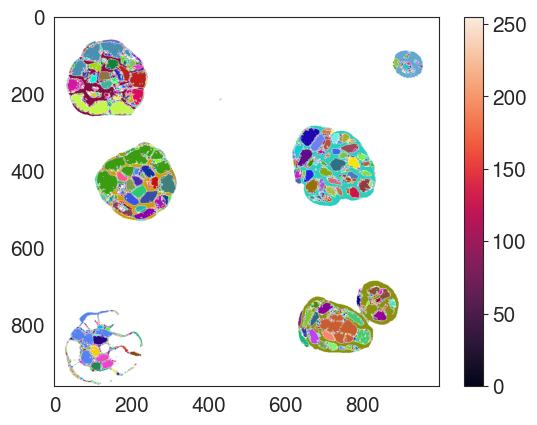

In [116]:
# Test whole 3D Watershed function on a sample image
# img_itk = _np2itk(imgs[0])
# ws_sample_itk = _itk2np(watershed_3d(img_itk))   
# ws_sample = _min_vol_filter((ws_sample_itk))

# plt.figure()
# plt.imshow(cp_plot.mask_rgb(ws_sample[160]))
# plt.colorbar()
# plt.show()

In [ ]:
# Apply 3D Watershed on Ovules
res_path = '../results/ovules/ws3d/'

for (img, fname) in zip(imgs, fnames):
    print('Predicting on {}...'.format(fname))
    ws_pred = _itk2np(watershed_3d(_np2itk(img)))
    ws_pred_filtered = min_vol_filter(ws_pred)
    np.save(os.path.join(res_path, fname+'.npy'), ws_pred_filtered)
    
    del ws_pred, ws_pred_filtered
    gc.collect()

#### Calculate metrics

In [9]:
res_path = '../results/ovules/ws3d/'V

In [8]:
%ls ../results/ovules/ws3d/

N_294_final_crop_ds2.npy  N_511_final_crop_ds2.npy  N_593_final_crop_ds2.npy
N_435_final_crop_ds2.npy  N_522_final_crop_ds2.npy
N_441_final_crop_ds2.npy  N_590_final_crop_ds2.npy


In [41]:
metrics = np.zeros((len(fnames), 7))

for i, fname in enumerate(fnames):
    print('Calculating metrics for {}...'.format(fname))
    y_pred = np.load(os.path.join(res_path, fname+'.npy')).astype(np.int64)
    y_true = masks[i]
    
    assert y_pred.shape == y_true.shape, "Inconsistent shapes btw ground-truth & predictions"
    
    ap25 = evaluation.average_precision(y_true, y_pred, 0.25)[0]
    ap75 = evaluation.average_precision(y_true, y_pred, 0.75)[0]
    ap50, tp, fp, fn = evaluation.average_precision(y_true, y_pred, 0.5)
    mAP = np.mean([ap25, ap50, ap75])
    prec, recall, f1 = tp/(tp+fp), tp/(tp+fn), tp/(tp+0.5*(fp+fn))
    
    metrics[i] = [prec, recall, f1, ap25, ap50, ap75, mAP]
    gc.collect()
    
del y_true, y_pred, ap25, ap50, ap75, tp, fp, fn, prec, recall, f1


Calculating metrics for N_294_final_crop_ds2...
Calculating metrics for N_435_final_crop_ds2...
Calculating metrics for N_441_final_crop_ds2...
Calculating metrics for N_511_final_crop_ds2...
Calculating metrics for N_522_final_crop_ds2...
Calculating metrics for N_590_final_crop_ds2...
Calculating metrics for N_593_final_crop_ds2...


In [42]:
metrics_df = pd.DataFrame(metrics, index=fnames, columns=['prec', 'recall', 'f1', 'AP25', 'AP50', 'AP75', 'mAP'])
metrics_df

,prec,recall,f1,AP25,AP50,AP75,mAP
N_294_final_crop_ds2,0.049994,0.110989,0.068936,0.164355,0.035699,0.000177,0.066743
N_435_final_crop_ds2,0.061308,0.258807,0.099133,0.073301,0.052151,0.000579,0.042011
N_441_final_crop_ds2,0.117571,0.487214,0.189430,0.144798,0.104624,0.006358,0.085260
N_511_final_crop_ds2,0.240363,0.332549,0.279039,0.401530,0.162141,0.000000,0.187890
N_522_final_crop_ds2,0.049032,0.221298,0.080278,0.055652,0.041817,0.000629,0.032699
N_590_final_crop_ds2,0.000000,0.000000,0.000000,0.004252,0.000000,0.000000,0.001417
N_593_final_crop_ds2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
metrics_df.mean(0)

prec      0.074038
recall    0.201551
f1        0.102402
AP25      0.120555
AP50      0.056633
AP75      0.001106
mAP       0.059432
dtype: float64

In [44]:
metrics_df.std(0)

prec      0.083554
recall    0.178829
f1        0.101133
AP25      0.139019
AP50      0.058492
AP75      0.002332
mAP       0.064728
dtype: float64

In [102]:
metrics_df.to_csv('../results/ovules/watershed.csv', index=True)

In [ ]:
# Visualize example predictions

# fname = fnames[-1]
# idx = 75
# sample_pred = np.load(os.path.join(res_path, fname+'.npy')).astype(np.int64)
# sample_pred_slices = _mask_to_rgb(sample_pred[idx-1:idx+2])

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10), dpi=300)
# ax1.imshow(sample_pred_slices[0])
# ax1.set_xticks([])
# ax1.set_yticks([])

# ax2.imshow(sample_pred_slices[0])
# ax2.set_xticks([])
# ax2.set_yticks([])

# ax3.imshow(sample_pred_slices[0])
# ax3.set_xticks([])
# ax3.set_yticks([])

# plt.tight_layout()
# plt.show()


### ATAS

In [197]:
atas_path = '../data/ATAS/'
atas_test_path = '../results/ATAS/cellpose2d/'  # Load ATAS filenames in test set 

# Load imgs & masks in the test set
fnames = [
    f.rpartition('.')[0]
    for f in sorted(os.listdir(atas_test_path))
    if f[-3:] == 'npy'
]

imgs = [
    np.load(os.path.join(atas_path, 'raw', f+'.npy'))
    for f in fnames
]

masks = [
    np.load(os.path.join(atas_path, 'labels', f+'.npy'))
    for f in fnames
]

assert len(imgs) == len(masks) == len(fnames), "Unequal # imgs & annotated masks in ATAS test set"
del atas_test_path


#### Prediction

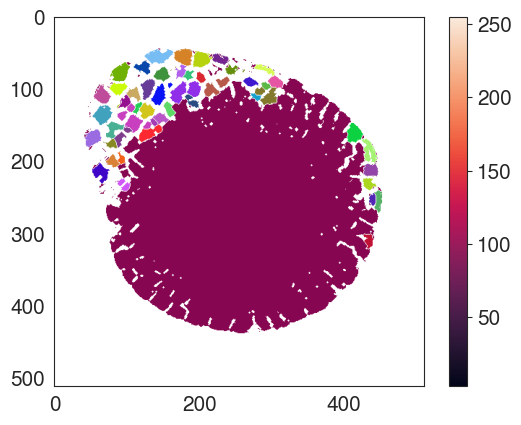

In [98]:
# # Test whole 3D Watershed function on a sample image
# img_itk = _np2itk(imgs[0][:5])
# ws_sample_itk = _itk2np(watershed_3d(img_itk))   
# ws_sample = min_vol_filter((ws_sample_itk))

# plt.figure()
# plt.imshow(cp_plot.mask_rgb(ws_sample[0]))
# plt.colorbar()
# plt.show()

# del img_itk, ws_sample, ws_sample_itk

In [100]:
# Apply 3D Watershed on ATAS
res_path = '../results/ATAS/ws3d/'

for (img, fname) in zip(imgs, fnames):
    print('Predicting on {}...'.format(fname))
    ws_pred = _itk2np(watershed_3d(_np2itk(img)))
    ws_pred_filtered = min_vol_filter(ws_pred)
    np.save(os.path.join(res_path, fname+'.npy'), ws_pred_filtered)
    
    del ws_pred, ws_pred_filtered
    gc.collect()

Predicting on 0hrs_plant13_trim-acylYFP...
Predicting on 0hrs_plant18_trim-acylYFP...
Predicting on 0hrs_plant2_trim-acylYFP...
Predicting on 12hrs_plant18_trim-acylYFP...
Predicting on 12hrs_plant2_trim-acylYFP...
Predicting on 20hrs_plant13_trim-acylYFP...
Predicting on 20hrs_plant2_trim-acylYFP...
Predicting on 24hrs_plant13_trim-acylYFP...
Predicting on 24hrs_plant15_trim-acylYFP...
Predicting on 28hrs_plant1_trim-acylYFP...
Predicting on 32hrs_plant13_trim-acylYFP...
Predicting on 36hrs_plant15_trim-acylYFP...
Predicting on 36hrs_plant2_trim-acylYFP...
Predicting on 40hrs_plant13_trim-acylYFP...
Predicting on 40hrs_plant1_trim-acylYFP...
Predicting on 40hrs_plant2_trim-acylYFP...
Predicting on 44hrs_plant18_trim-acylYFP...
Predicting on 44hrs_plant2_trim-acylYFP...
Predicting on 44hrs_plant4_trim-acylYFP...
Predicting on 48hrs_plant15_trim-acylYFP...
Predicting on 48hrs_plant4_trim-acylYFP...
Predicting on 4hrs_plant15_trim-acylYFP...
Predicting on 52hrs_plant2_trim-acylYFP...
Pre

#### Calculate metrics

In [105]:
metrics = np.zeros((len(fnames), 7))

for i, fname in enumerate(fnames):
    print('Calculating metrics for {}...'.format(fname))
    y_pred = np.load(os.path.join(res_path, fname+'.npy')).astype(np.int64)
    y_true = masks[i]
    
    assert y_pred.shape == y_true.shape, "Inconsistent shapes btw ground-truth & predictions"
    
    ap25 = evaluation.average_precision(y_true, y_pred, 0.25)[0]
    ap75 = evaluation.average_precision(y_true, y_pred, 0.75)[0]
    ap50, tp, fp, fn = evaluation.average_precision(y_true, y_pred, 0.5)
    mAP = np.mean([ap25, ap50, ap75])
    prec, recall, f1 = tp/(tp+fp), tp/(tp+fn), tp/(tp+0.5*(fp+fn))
    
    metrics[i] = [prec, recall, f1, ap25, ap50, ap75, mAP]
    gc.collect()
    
del y_true, y_pred, ap25, ap50, ap75, tp, fp, fn, prec, recall, f1


Calculating metrics for 0hrs_plant13_trim-acylYFP...
Calculating metrics for 0hrs_plant18_trim-acylYFP...
Calculating metrics for 0hrs_plant2_trim-acylYFP...
Calculating metrics for 12hrs_plant18_trim-acylYFP...
Calculating metrics for 12hrs_plant2_trim-acylYFP...
Calculating metrics for 20hrs_plant13_trim-acylYFP...
Calculating metrics for 20hrs_plant2_trim-acylYFP...
Calculating metrics for 24hrs_plant13_trim-acylYFP...
Calculating metrics for 24hrs_plant15_trim-acylYFP...
Calculating metrics for 28hrs_plant1_trim-acylYFP...
Calculating metrics for 32hrs_plant13_trim-acylYFP...
Calculating metrics for 36hrs_plant15_trim-acylYFP...
Calculating metrics for 36hrs_plant2_trim-acylYFP...
Calculating metrics for 40hrs_plant13_trim-acylYFP...
Calculating metrics for 40hrs_plant1_trim-acylYFP...
Calculating metrics for 40hrs_plant2_trim-acylYFP...
Calculating metrics for 44hrs_plant18_trim-acylYFP...
Calculating metrics for 44hrs_plant2_trim-acylYFP...
Calculating metrics for 44hrs_plant4_tr

In [106]:
metrics_df = pd.DataFrame(metrics, index=fnames, columns=['prec', 'recall', 'f1', 'AP25', 'AP50', 'AP75', 'mAP'])
metrics_df.head()

,prec,recall,f1,AP25,AP50,AP75,mAP
0hrs_plant13_trim-acylYFP,0.247191,0.027295,0.049162,0.105384,0.025200,0.0,0.043528
0hrs_plant18_trim-acylYFP,0.114943,0.013141,0.023585,0.076372,0.011933,0.0,0.029435
0hrs_plant2_trim-acylYFP,0.000000,0.000000,0.000000,0.012959,0.000000,0.0,0.004320
12hrs_plant18_trim-acylYFP,0.100000,0.004950,0.009434,0.016588,0.004739,0.0,0.007109
12hrs_plant2_trim-acylYFP,0.100000,0.006656,0.012480,0.015699,0.006279,0.0,0.007326


In [108]:
metrics_df.mean(0)

prec      0.069438
recall    0.006629
f1        0.011932
AP25      0.041919
AP50      0.006063
AP75      0.000000
mAP       0.015994
dtype: float64

In [109]:
metrics_df.std(0)

prec      0.076270
recall    0.008729
f1        0.015511
AP25      0.035562
AP50      0.007991
AP75      0.000000
mAP       0.013741
dtype: float64

In [110]:
metrics_df.to_csv('../results/ATAS/watershed.csv', index=True)

### Arabidposis Thaliana Atlas 
(Anther, Filament, Leaf, Pedicel, Sepal, Valve)

#### Prediction

TODO: convert img to RGB (0-255)

In [206]:
# Load filenames from each subdirectory

plant_atlas_path = '../data/plant_atlas/'
regions = ['Anther', 'Filament', 'Leaf', 'Pedicel', 'Sepal', 'Valve']

fnames = []
imgs = []
masks = []

for region in regions:
    img_path = os.path.join(plant_atlas_path, region)
    mask_path = os.path.join(plant_atlas_path, region+'_masks')
    
    curr_fnames = [
        f.rpartition('.')[0]
        for f in sorted(os.listdir(img_path))
        if f[-3:] == 'tif'
    ]
    
    curr_imgs = [
        np.round(tifffile.imread(os.path.join(img_path, f+'.tif'))*255).astype(np.int64)  # Convert to [0-255]
        for f in curr_fnames
    ]
    
    curr_masks = [
        tifffile.imread(os.path.join(mask_path, f+'.tif')).astype(np.int64)
        for f in curr_fnames
    ]
    
    fnames.extend(curr_fnames)
    imgs.extend(curr_imgs)
    masks.extend(curr_masks)
    
del region, img_path, mask_path, curr_fnames, curr_imgs, curr_masks

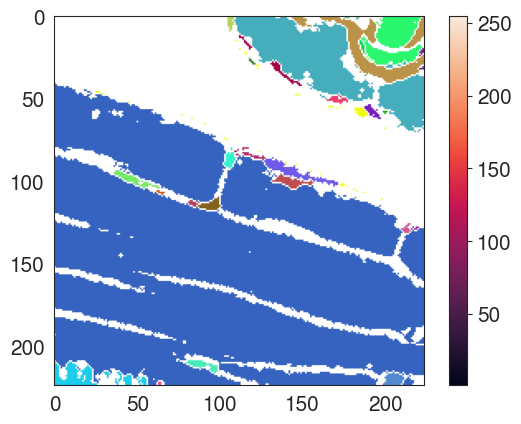

In [215]:
# Test whole 3D Watershed function on a sample image
# img_itk = _np2itk(imgs[0])
# ws_sample_itk = _itk2np(watershed_3d(img_itk))   
# ws_sample = min_vol_filter((ws_sample_itk))

# plt.figure()
# plt.imshow(cp_plot.mask_rgb(ws_sample[10]))
# plt.colorbar()
# plt.show()

In [218]:
# Apply 3D Watershed on Plant Atlas
res_path = '../results/Plant_atlas/'

for (img, fname) in zip(imgs, fnames):
    print('Predicting on {}...'.format(fname))
    ws_pred = _itk2np(watershed_3d(_np2itk(img)))
    ws_pred_filtered = min_vol_filter(ws_pred)
    np.save(os.path.join(res_path, fname+'.npy'), ws_pred_filtered)
    
    del ws_pred, ws_pred_filtered
    gc.collect()

Predicting on Anther_20...
Predicting on Anther_21...
Predicting on Anther_22...
Predicting on Anther_23...
Predicting on Anther_24...
Predicting on Anther_25...
Predicting on Anther_26...
Predicting on Anther_27...
Predicting on Anther_28...
Predicting on Anther_29...
Predicting on Anther_30...
Predicting on Anther_31...
Predicting on Anther_32...
Predicting on Anther_33...
Predicting on Anther_34...
Predicting on Anther_35...
Predicting on Anther_36...
Predicting on Anther_37...
Predicting on Anther_38...
Predicting on Anther_39...
Predicting on Anther_40...
Predicting on Anther_41...
Predicting on Anther_42...
Predicting on Anther_43...
Predicting on Anther_44...
Predicting on Anther_45...
Predicting on Anther_46...
Predicting on Anther_47...
Predicting on Anther_48...
Predicting on Anther_49...
Predicting on Filament_20...
Predicting on Filament_21...
Predicting on Filament_22...
Predicting on Filament_23...
Predicting on Filament_24...
Predicting on Filament_25...
Predicting on Fi

#### Calculate metrics

In [219]:
res_path = '../results/Plant_atlas/'
metrics = np.zeros((len(fnames), 7))

for i, fname in enumerate(fnames):
    print('Calculating metrics for {}...'.format(fname))
    y_pred = np.load(os.path.join(res_path, fname+'.npy')).astype(np.int64)
    y_true = masks[i]
    
    assert y_pred.shape == y_true.shape, "Inconsistent shapes btw ground-truth & predictions"
    
    ap25 = evaluation.average_precision(y_true, y_pred, 0.25)[0]
    ap75 = evaluation.average_precision(y_true, y_pred, 0.75)[0]
    ap50, tp, fp, fn = evaluation.average_precision(y_true, y_pred, 0.5)
    mAP = np.mean([ap25, ap50, ap75])
    prec, recall, f1 = tp/(tp+fp), tp/(tp+fn), tp/(tp+0.5*(fp+fn))
    
    metrics[i] = [prec, recall, f1, ap25, ap50, ap75, mAP]
    gc.collect()
    
del y_true, y_pred, ap25, ap50, ap75, tp, fp, fn, prec, recall, f1

Calculating metrics for Anther_20...
Calculating metrics for Anther_21...
Calculating metrics for Anther_22...
Calculating metrics for Anther_23...
Calculating metrics for Anther_24...
Calculating metrics for Anther_25...
Calculating metrics for Anther_26...
Calculating metrics for Anther_27...
Calculating metrics for Anther_28...
Calculating metrics for Anther_29...
Calculating metrics for Anther_30...
Calculating metrics for Anther_31...
Calculating metrics for Anther_32...
Calculating metrics for Anther_33...
Calculating metrics for Anther_34...
Calculating metrics for Anther_35...
Calculating metrics for Anther_36...
Calculating metrics for Anther_37...
Calculating metrics for Anther_38...
Calculating metrics for Anther_39...
Calculating metrics for Anther_40...
Calculating metrics for Anther_41...
Calculating metrics for Anther_42...
Calculating metrics for Anther_43...
Calculating metrics for Anther_44...
Calculating metrics for Anther_45...
Calculating metrics for Anther_46...
C

In [220]:
metrics_df = pd.DataFrame(metrics, index=fnames, columns=['prec', 'recall', 'f1', 'AP25', 'AP50', 'AP75', 'mAP'])

In [224]:
# metrics_df = pd.DataFrame(metrics, index=fnames, columns=['prec', 'recall', 'f1', 'AP25', 'AP50', 'AP75', 'mAP'])
for region in regions:
    print('Metrics for {}:'.format(region))
    print('===============')
    region_metrics_df = metrics_df[metrics_df.index.str.contains(region)]
    
    print('Mean:')
    display(region_metrics_df.mean(0))
    print('\nStd:')
    display(region_metrics_df.std(0))
    print('\n\n')
    
del region, region_metrics_df

Metrics for Anther:
Mean:


prec      0.027262
recall    0.031384
f1        0.028056
AP25      0.066428
AP50      0.014662
AP75      0.000866
mAP       0.027319
dtype: float64


Std:


prec      0.038752
recall    0.048375
f1        0.040886
AP25      0.062605
AP50      0.021669
AP75      0.004742
mAP       0.026577
dtype: float64




Metrics for Filament:
Mean:


prec      0.044927
recall    0.147558
f1        0.068334
AP25      0.114162
AP50      0.035699
AP75      0.000000
mAP       0.049953
dtype: float64


Std:


prec      0.021684
recall    0.088619
f1        0.034547
AP25      0.030445
AP50      0.018710
AP75      0.000000
mAP       0.014220
dtype: float64




Metrics for Leaf:
Mean:


prec      0.000000
recall    0.000000
f1        0.000000
AP25      0.000267
AP50      0.000000
AP75      0.000000
mAP       0.000089
dtype: float64


Std:


prec      0.000000
recall    0.000000
f1        0.000000
AP25      0.000817
AP50      0.000000
AP75      0.000000
mAP       0.000272
dtype: float64




Metrics for Pedicel:
Mean:


prec      0.026216
recall    0.041628
f1        0.030597
AP25      0.055910
AP50      0.015809
AP75      0.001597
mAP       0.024439
dtype: float64


Std:


prec      0.027163
recall    0.047300
f1        0.032568
AP25      0.039400
AP50      0.017069
AP75      0.004203
mAP       0.018802
dtype: float64




Metrics for Sepal:
Mean:


prec      0.028810
recall    0.021133
f1        0.022864
AP25      0.034793
AP50      0.012056
AP75      0.000000
mAP       0.015616
dtype: float64


Std:


prec      0.047764
recall    0.044223
f1        0.043280
AP25      0.041342
AP50      0.023273
AP75      0.000000
mAP       0.020579
dtype: float64




Metrics for Valve:
Mean:


prec      0.000000
recall    0.000000
f1        0.000000
AP25      0.008253
AP50      0.000000
AP75      0.000000
mAP       0.002751
dtype: float64


Std:


prec      0.000000
recall    0.000000
f1        0.000000
AP25      0.004788
AP50      0.000000
AP75      0.000000
mAP       0.001596
dtype: float64

---